Conversion from CellRank pipeline
=================================
The aim of this notebook is to convert resulting analysis from CellRank into a principal tree that can be used by scFates

CellRank aims at identifying fate potentials by considering single cell dynamics as a Markov process (see [Lange et al., biorxiv, 2021](https://www.biorxiv.org/content/10.1101/2020.10.19.345983v2)). This is a great tool for finding the macrostates such as the "tips" of our trajectories, thanks to its powerful probabilistic approach. Here we propose to extend it by converting the fate probabilities into a principal tree, allowing easier interpretation of what is happening "in between" (early biases, bifurcations).

## Setting up environment modules and basic settings

### Generating the environment

The following needs to be run in the command-line

```bash
conda create -n scFates -c conda-forge -c r python=3.8 r-mgcv rpy2=3.4.2 -y
conda activate scFates

# Install new jupyter server
conda install -c conda-forge jupyter

# Or add to an existing jupyter server
conda install -c conda-forge ipykernel
python -m ipykernel install --user --name scFates --display-name "scFates"

# Install scFates
pip install scFates
```

### Required additional packages

In [1]:
import sys
!{sys.executable} -m pip -q install scvelo cellrank

### Loading modules and settings

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

In [3]:
import warnings
warnings.simplefilter("ignore", category = UserWarning)
warnings.simplefilter("ignore", category = FutureWarning)
warnings.simplefilter("ignore", category = DeprecationWarning)

## Reproduction of CellRank notebook

Here we run a compressed version of the CellRank [notebook](https://nbviewer.org/github/theislab/cellrank_reproducibility/blob/master/notebooks/fig_2_pancreas_main/ML_2021-09-21_fig_2_and_3_pancreas_main.ipynb) which reproduces figure 2 of their paper.

In [4]:
adata = cr.datasets.pancreas(kind="preprocessed-kernel")

vk = cr.kernels.VelocityKernel.from_adata(adata, key="T_fwd")
vk

VelocityKernel[n=2531, model='deterministic', similarity='correlation', softmax_scale=4.013]

In [5]:
g = cr.estimators.GPCCA(vk)
print(g)

GPCCA[kernel=VelocityKernel[n=2531], initial_states=None, terminal_states=None]


In [6]:
g.compute_macrostates(n_states=11, cluster_key="clusters")

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 10]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:06)
Computing `11` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:09)


GPCCA[kernel=VelocityKernel[n=2531], initial_states=None, terminal_states=None]

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


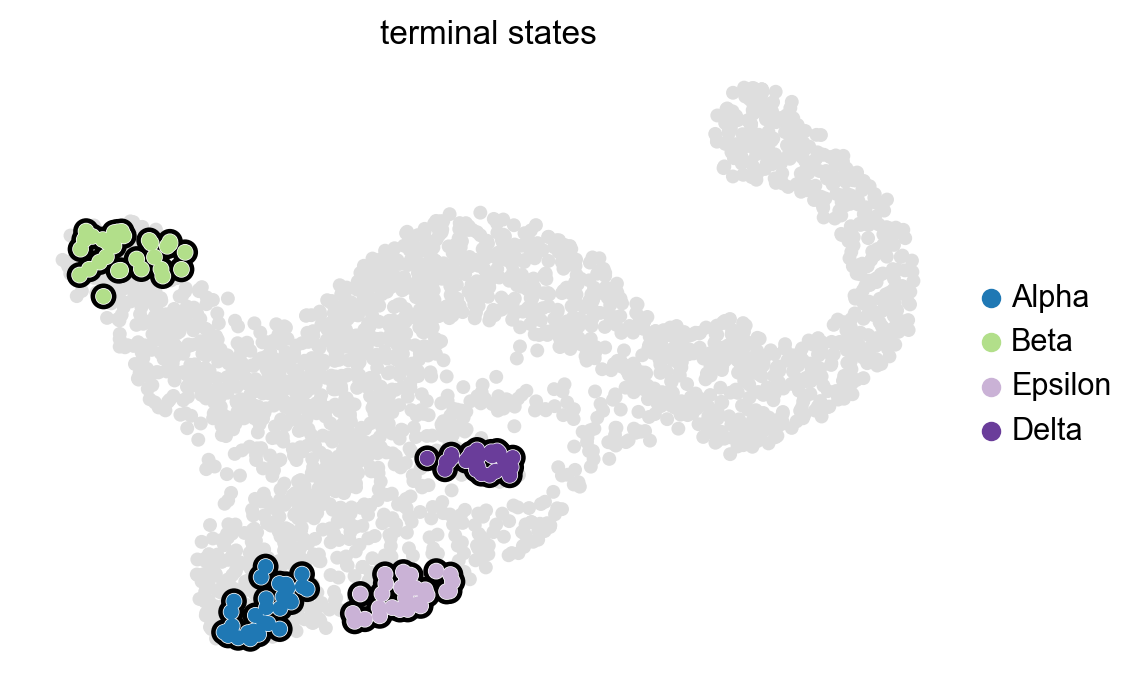

In [7]:
g.set_terminal_states(states=["Alpha", "Beta", "Epsilon", "Delta"])
g.plot_macrostates(which="terminal", legend_loc="right", s=100)

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


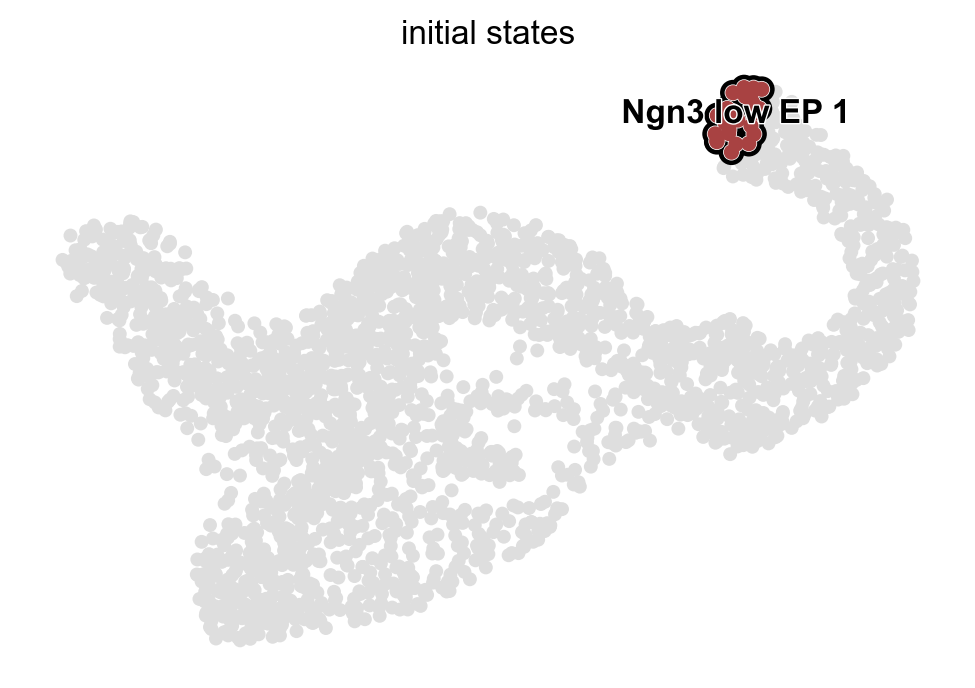

In [8]:
g.predict_initial_states()
g.plot_macrostates(which="initial", s=100)

Computing fate probabilities
Defaulting to `'gmres'` solver.


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


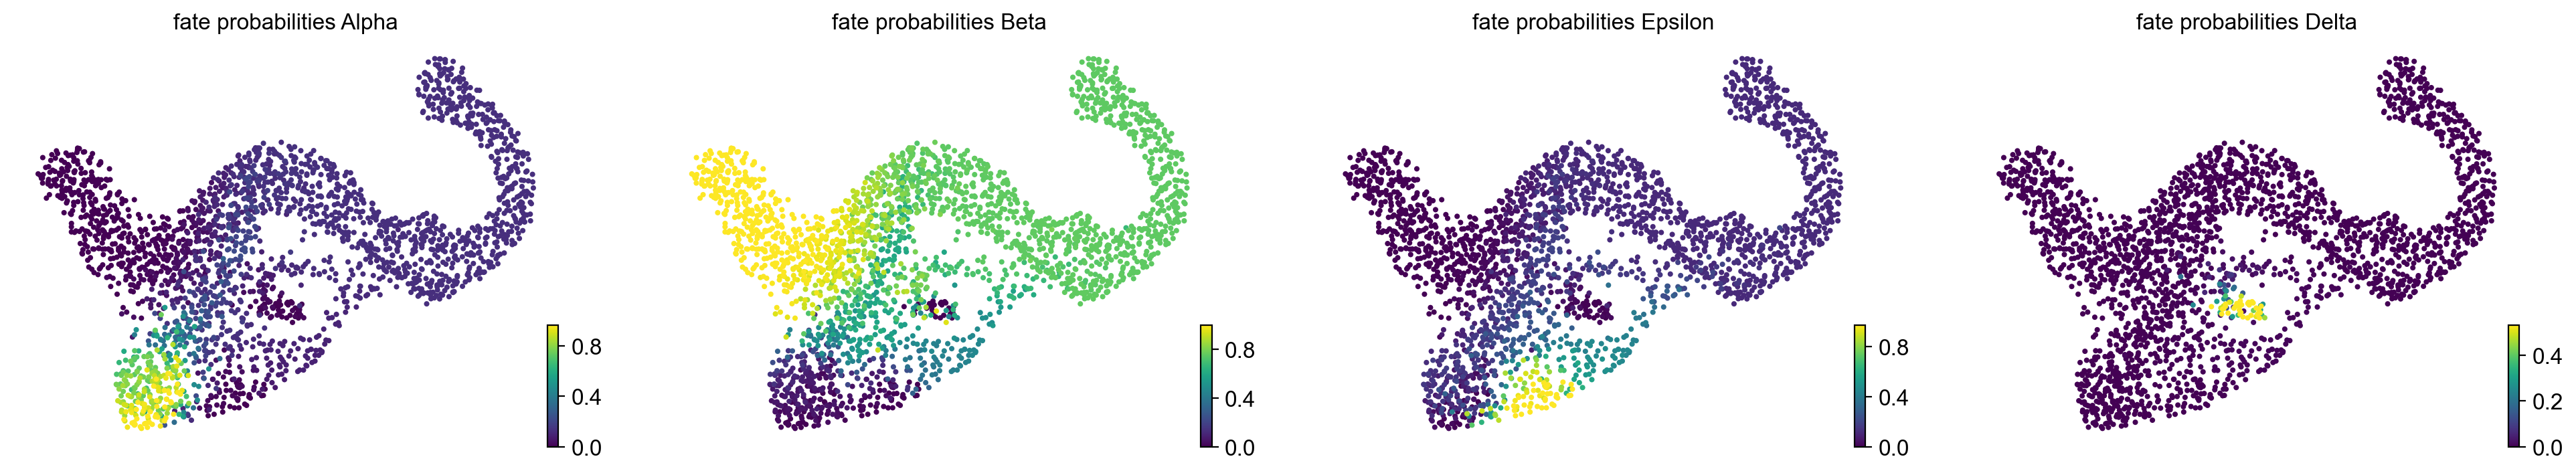

In [9]:
g.compute_fate_probabilities()
g.plot_fate_probabilities(same_plot=False)

## Converting Cellrank output into a principal tree

In [10]:
import scFates as scf

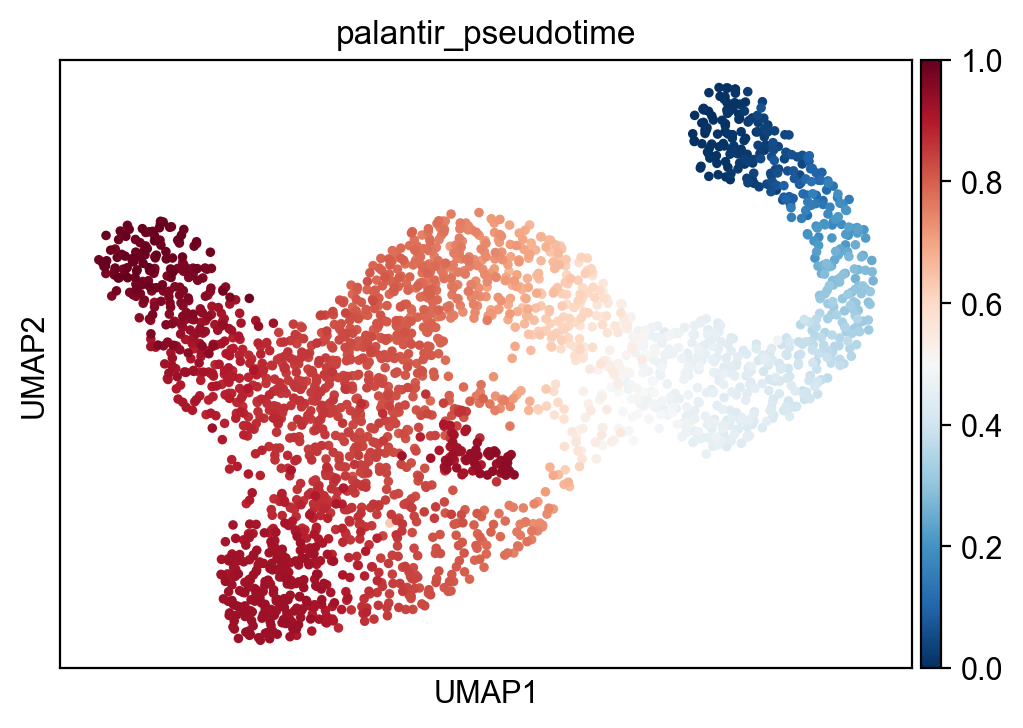

In [13]:
sc.pl.umap(adata,color="palantir_pseudotime")

In [14]:
scf.tl.cellrank_to_tree(adata,time="palantir_pseudotime",Nodes=300,seed=1)

Converting CellRank results to a principal tree --> with .obsm['X_fates'], created by combining:
    .obsm['X_fate_simplex_fwd'] (from cr.pl.circular_projection) and adata.obs['palantir_pseudotime']

Solving TSP for `4` states
inferring a principal tree --> parameters used 
    300 principal points, sigma = 0.1, lambda = 100, metric = euclidean
    fitting:   2%|█▊                                                                                           | 1/50 [00:00<00:20,  2.36it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    fitting:  50%|██████████████████████████████████████████████                                              | 25/50 [00:00<00:00, 38.50it/s]
    converged
    finished (0:00:00) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.

finished (0:00:41)     .obsm['X_fates'] representation used for fitting the tree.
    .uns['graph']['pp_info'].time has been updated with palantir_pseudotime
    .uns['graph']['pp_seg'].d has been updated with palantir_pseudotime


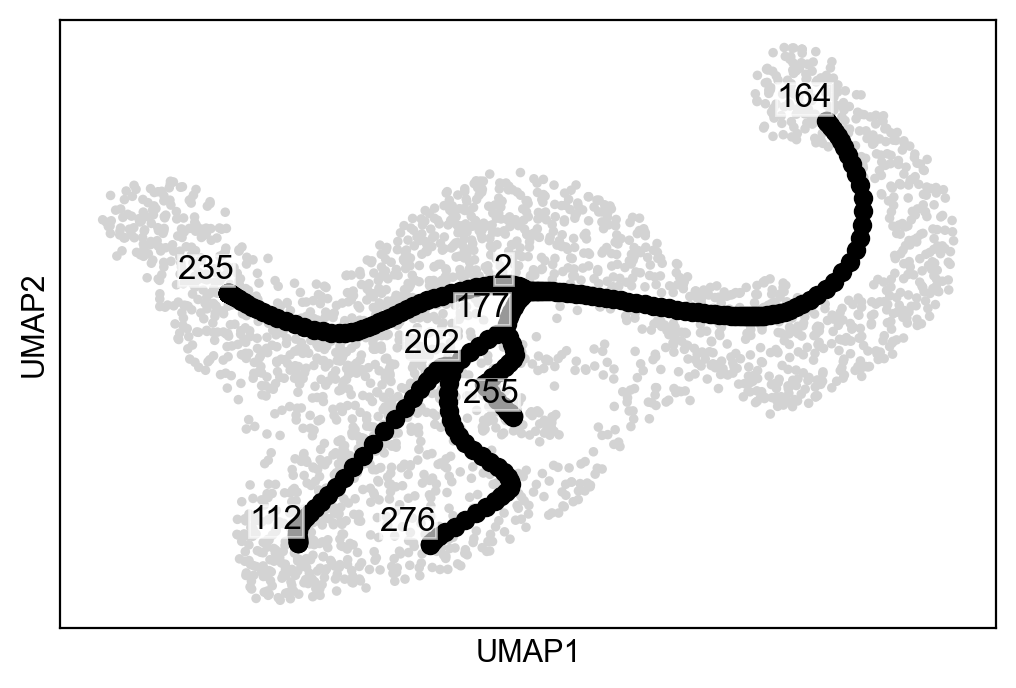

In [15]:
scf.pl.graph(adata)

In [16]:
scf.tl.root(adata,164)
scf.tl.pseudotime(adata,n_jobs=10,n_map=100,seed=42)

node 164 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    mappings: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]
    finished (0:00:19) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


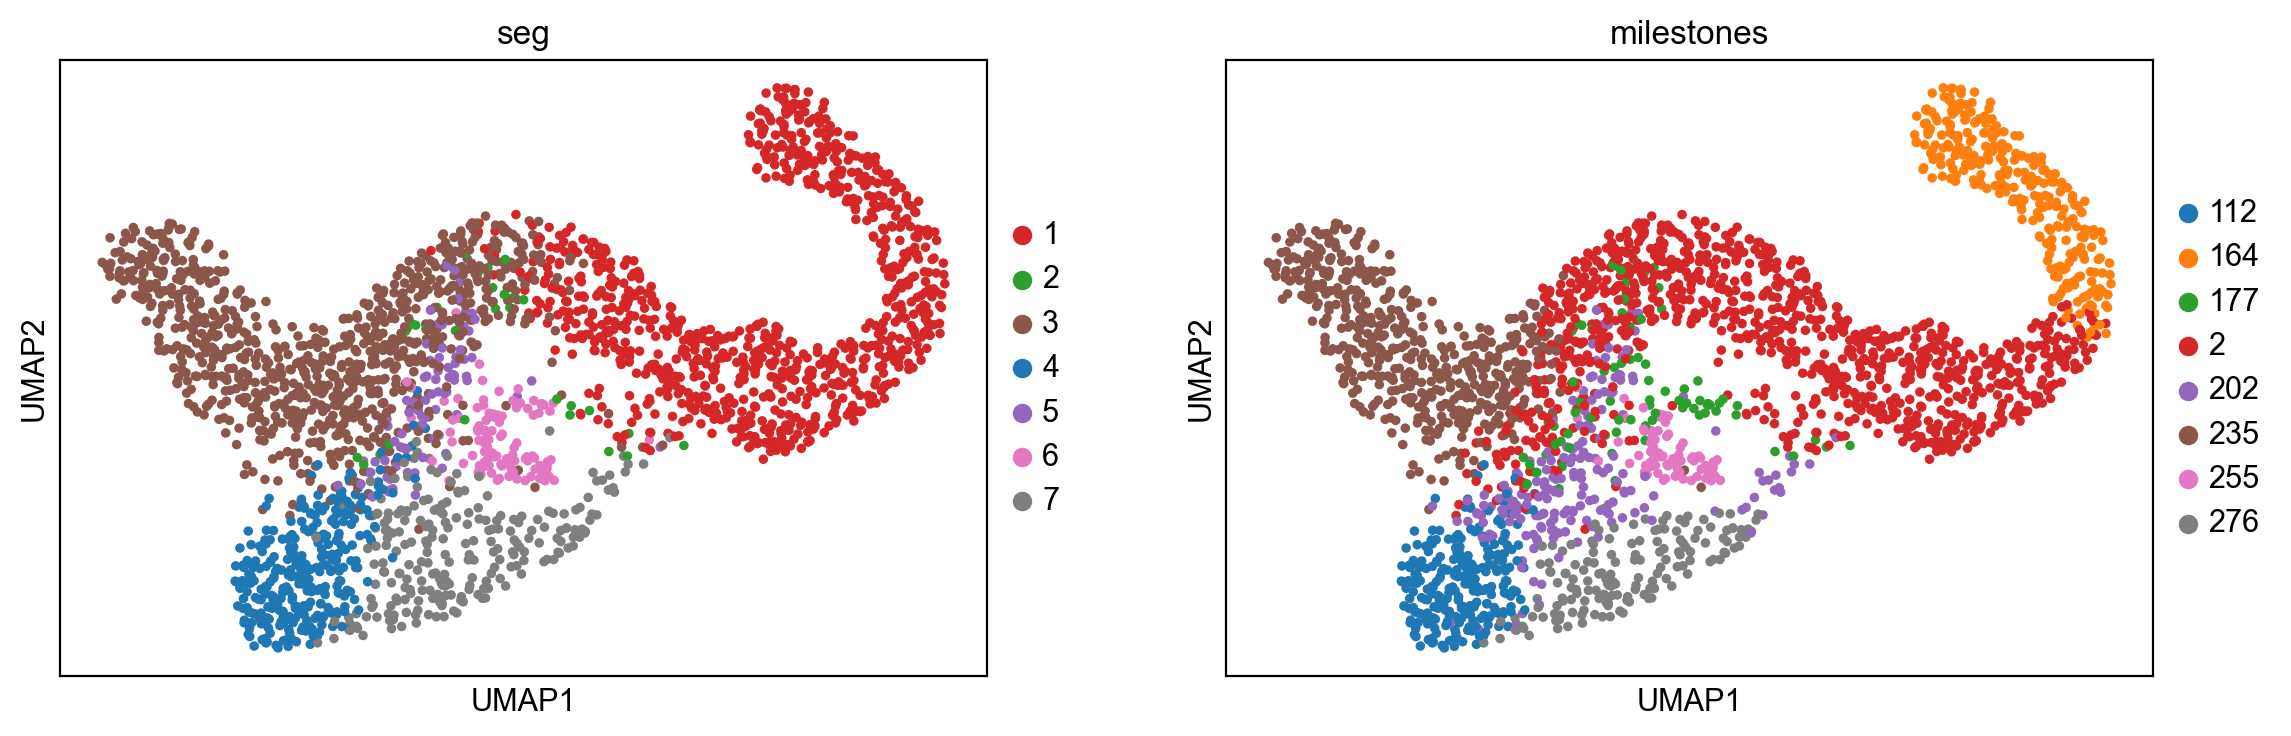

In [17]:
sc.pl.umap(adata,color=["seg","milestones"])

In [18]:
# to avoid overlapping of labels, we set some intermediate states to empty strings of varying length
dct={"112":"Alpha","235":"Beta","2":"Ngn3 high EP","276":"Epsilon","255":"Delta","177":"  ","202":" ","164":"Ngn3 low EP"}

In [19]:
scf.tl.rename_milestones(adata,dct)

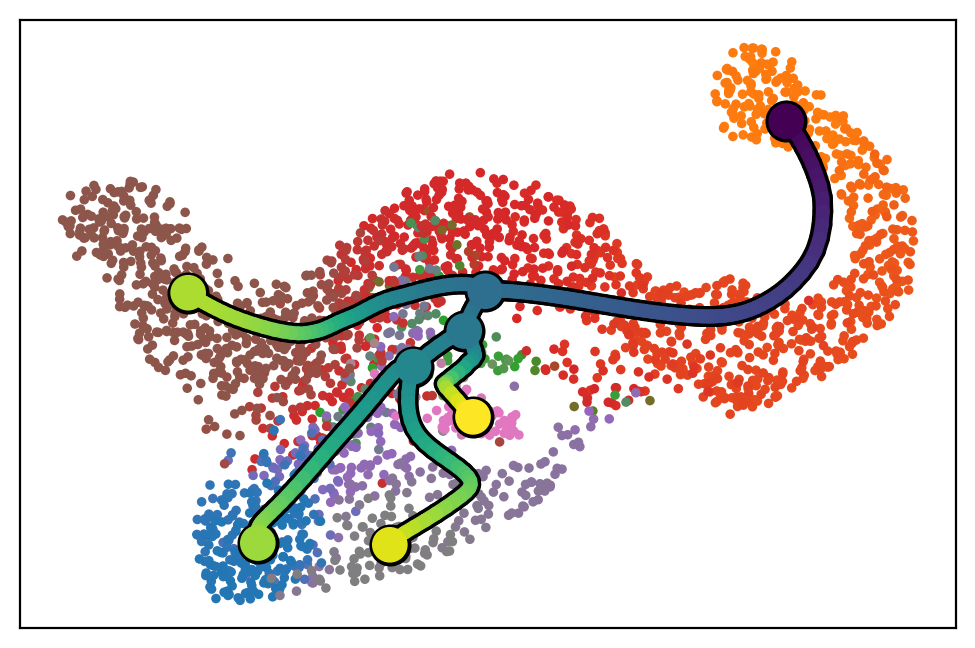

In [20]:
scf.pl.trajectory(adata,color_cells="milestones")

In [21]:
scf.tl.dendrogram(adata)

Generating dendrogram of tree
    segment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.12it/s]
    finished (0:00:00) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


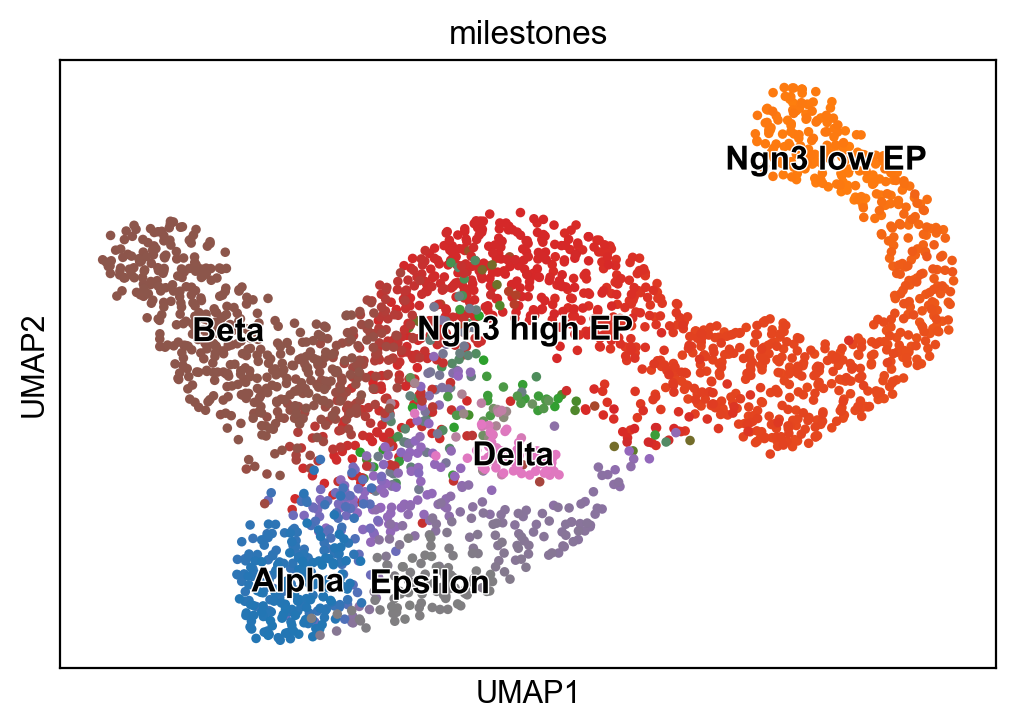

In [23]:
scf.pl.milestones(adata,annotate=True)

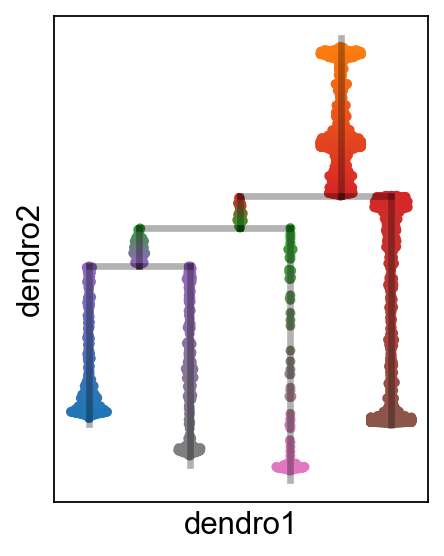

In [25]:
sc.set_figure_params(figsize=(3,4))
scf.pl.dendrogram(adata,color_milestones=True)